<a href="https://colab.research.google.com/github/vskrch/Fun_Projects/blob/master/Apparel_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#import all the necessary packages.
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

### Go to [tops_fashion.json](https://drive.google.com/file/d/11ch_27I3oqGlu-VhYyWJmEk6nLO3wdRE/view?usp=sharing) 

In [7]:
from pprint import pprint
data = pd.read_json('/content/drive/My Drive/tops_fashion.json')
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])

pprint(data.columns)
data.to_pickle('/content/drive/My Drive/180k_apparel_data')

Number of data points :  183138 Number of features/variables: 19
Index(['sku', 'asin', 'product_type_name', 'formatted_price', 'author',
       'color', 'brand', 'publisher', 'availability', 'reviews',
       'large_image_url', 'availability_type', 'small_image_url',
       'editorial_review', 'title', 'model', 'medium_image_url',
       'manufacturer', 'editorial_reivew'],
      dtype='object')


Of these 19 features, we will be using only 6 features in this workshop.
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [8]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [0]:
data = pd.read_pickle('/content/drive/My Drive/180k_apparel_data')

# Data Preprocessing

### Removing Null Values

In [12]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

data.to_pickle('/content/drive/My Drive/28k_apparel_data')

Number of data points After eliminating price=NULL : 28385
Number of data points After eliminating color=NULL : 28385


In [13]:
#for dowloading images from the json file containg the links of the images 
'''from PIL import Image
import requests
from io import BytesIO

for index,row in data.iterrows():
        url = row['medium_image_url']
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        img.save('images/'+row['asin']+'.jpeg')'''

"from PIL import Image\nimport requests\nfrom io import BytesIO\n\nfor index,row in data.iterrows():\n        url = row['medium_image_url']\n        response = requests.get(url)\n        img = Image.open(BytesIO(response.content))\n        img.save('images/'+row['asin']+'.jpeg')"

### Removing the products with short description

In [14]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


### Removing the products with duplicate title by sorting 

<pre>
Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
</pre>

In [16]:
data = pd.read_pickle('/content/drive/My Drive/28k_apparel_data')
print('The number of entries with duplicate title is %d'%sum(data.duplicated('title')))
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:    
    previous_i = i
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()
    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()
        # store the maximum length of two strings
        length = max(len(a), len(b))
        # count is used to store the number of words that are matched in both strings
        count  = 0
        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points now is: ', data.shape[0])
#data.to_pickle('pickels/17k_apparrel_data')

The number of entries with duplicate title is 2325
Number of data points now is:  17593


<pre>

In the previous cell, we sorted whole data in alphabetical order of  titles.Then, we removed titles which are adjacent and very similar title

But there are some products whose titles are not adjacent but very similar.

Examples:

Titles-1
86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

TItles-2
75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

</pre>

In [17]:
# below code takes a lot of time about 1hr hence commented and processed pickle file saved
'''
data = pd.read_pickle('pickels/17k_apparrel_data')
indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        length = max(len(a),len(b))        
        # count is used to store the number of words that are matched in both strings
        count  = 0
        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1
        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)
            
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]
print('Number of data points after stage two of dedupe: ',data.shape[0])
data.to_pickle('pickels/16k_apperal_data')'''

"\ndata = pd.read_pickle('pickels/17k_apparrel_data')\nindices = []\nfor i,row in data.iterrows():\n    indices.append(i)\n\nstage2_dedupe_asins = []\nwhile len(indices)!=0:\n    i = indices.pop()\n    stage2_dedupe_asins.append(data['asin'].loc[i])\n    # consider the first apperal's title\n    a = data['title'].loc[i].split()\n    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']\n    for j in indices:        \n        b = data['title'].loc[j].split()\n        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']\n        length = max(len(a),len(b))        \n        # count is used to store the number of words that are matched in both strings\n        count  = 0\n        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings\n        # example: a =['a', '

### Go to [Saved 16k_apparel_data](https://drive.google.com/open?id=1yDZDY2Y-4VvPSxJeCyPhqhxfNtAW9e6j)
<pre>
And create a folder named pickels and move this file into this folder
</pre>

# Text Preprocessing

In [20]:
import nltk
nltk.download('stopwords')
data = pd.read_pickle('/content/drive/My Drive/16k_apperal_data')
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
list of stop words: {'don', 'over', 'or', 'once', 'has', "you'll", 'only', "don't", 't', 'ma', "mightn't", 'your', 'doesn', 'because', "isn't", "wouldn't", 'each', 'my', 'yours', 'down', 'how', 'theirs', 'y', 'they', 'most', 'more', 'ourselves', 'mustn', 'aren', 'to', 'doing', 'too', 'hers', "shan't", 'of', 'that', "she's", 'does', "doesn't", 'these', 've', 'nor', "won't", 'o', 'on', 'an', 'here', 'you', 'the', 'while', 'some', "needn't", 'from', 'him', 'yourself', 'in', 'have', 'd', 'should', 'had', 'below', 'a', 'under', 'such', 'if', 'mightn', 'themselves', 'who', 'wasn', 'during', "haven't", 'before', 'above', 'both', 'll', 'was', 'will', 'why', 'few', 'been', 'which', 'being', 'no', 'than', 'again', 'ain', 'isn', 'very', 'then', 'off', 'own', 'her', 'now', 'just', "hasn't", "you've", 'up', 'herself', 'all', 'hasn', 'their', 'between', 'myself', "you'd", 'couldn', 'whom', 

In [21]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

data.head()
#data.to_pickle('/content/drive/My Drive/16k_apparel_data_preprocessed')

6.010437000000003 seconds


In [0]:
# Utility Functions

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

#plotting code to understand the decision  
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url
        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf
    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_heatmap(keys, values, labels, url, text)

# this function gets a list of wrods along with the frequency of each word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' 
    #this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, 
    #it returns dict type object {word1:count}

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)
    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)
    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## 1.Bag of Words model on Product Titles

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        bag_of_words_euclidean.append(pdists[i])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)
    print('Average euclidean distance is ',sum(bag_of_words_euclidean)/num_results)



Getting the similar items for document id and number of items


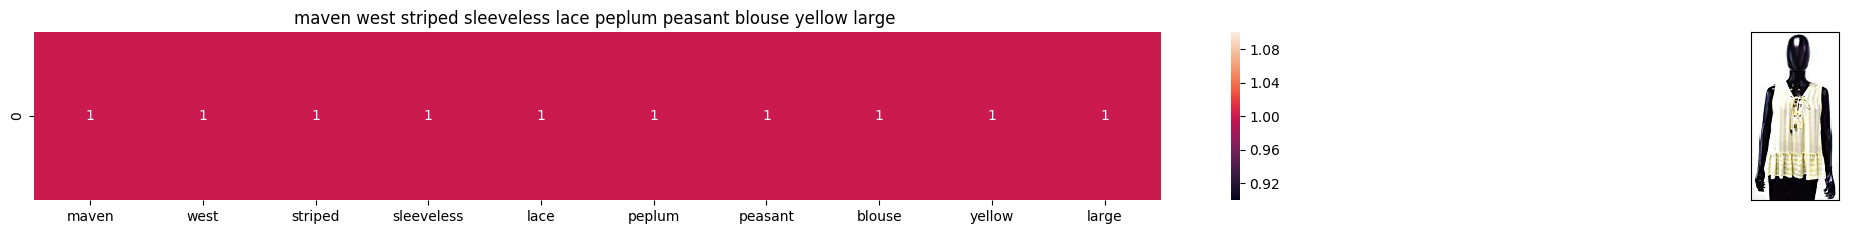

ASIN : B01M8GB3AL
Brand: Maven West
Title: maven west striped sleeveless lace peplum peasant blouse yellow large 
Euclidean similarity with the query image : 0.0


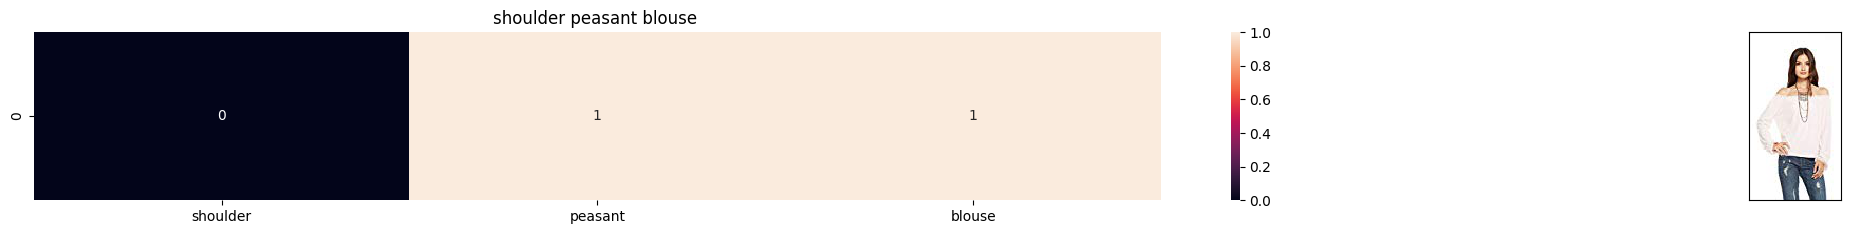

ASIN : B01E1QD5PK
Brand: CHASER
Title: shoulder peasant blouse 
Euclidean similarity with the query image : 3.0


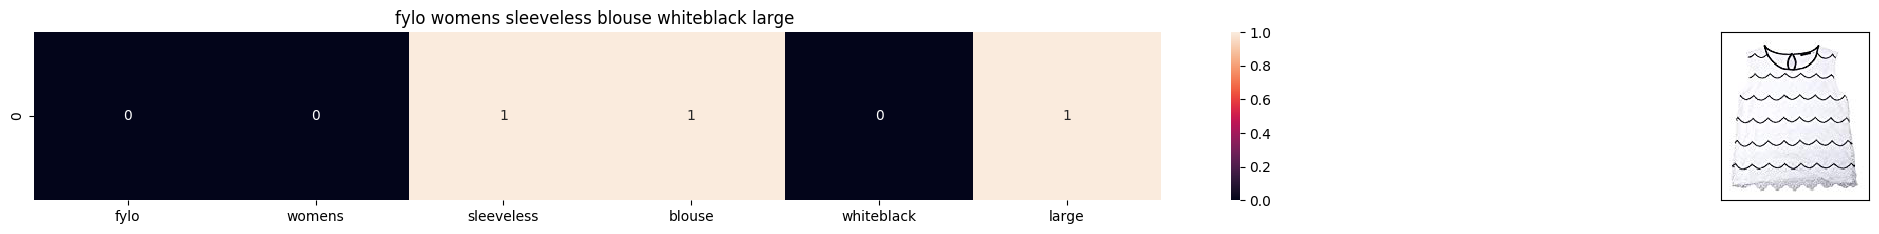

ASIN : B074LZGQ6L
Brand: Fylo
Title: fylo womens sleeveless blouse whiteblack large 
Euclidean similarity with the query image : 3.1622776601683795


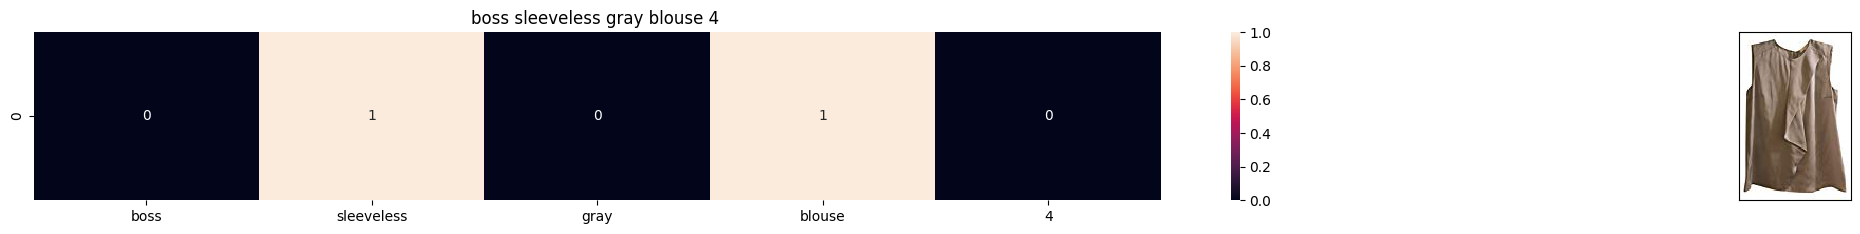

ASIN : B01N9AG9WK
Brand: HUGO BOSS
Title: boss sleeveless gray blouse 4 
Euclidean similarity with the query image : 3.1622776601683795


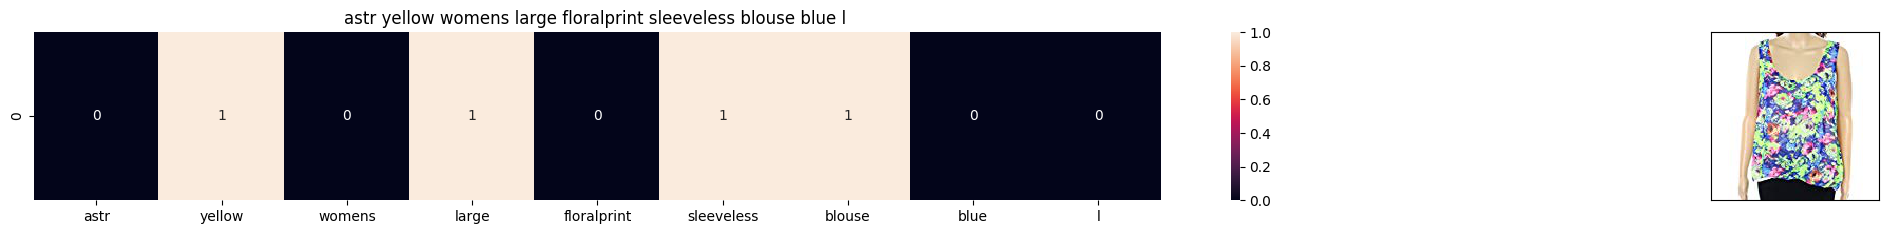

ASIN : B0725VVD59
Brand: ASTR
Title: astr yellow womens large floralprint sleeveless blouse blue l 
Euclidean similarity with the query image : 3.1622776601683795
Average euclidean distance is  2.497366596101028


In [55]:
#call the bag-of-words model for a product to get similar products.
print('Getting the similar items for document id and number of items')
bag_of_words_model(5000, 5)
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

## 2.TF-IDF BASED PRODUCT SIMILARITY

In [0]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
# tfidf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# tfidf_title_features[doc_id, index_of_word_in_corpus] = tfidf values of the word in given doc
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        tf_idf_euclidean.append(pdists[i])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is',sum(tf_idf_euclidean)/num_results)


Getting the similar items for document id and number of items


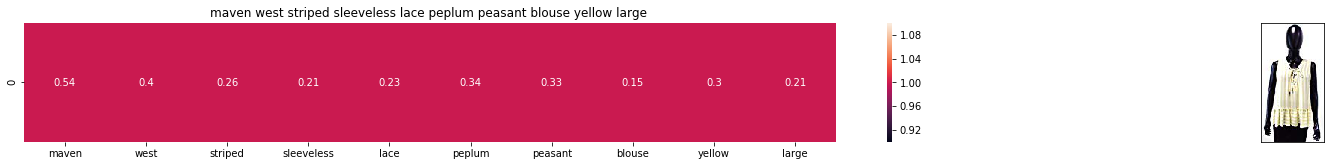

ASIN : B01M8GB3AL
BRAND : Maven West
Eucliden distance from the given image : 0.0


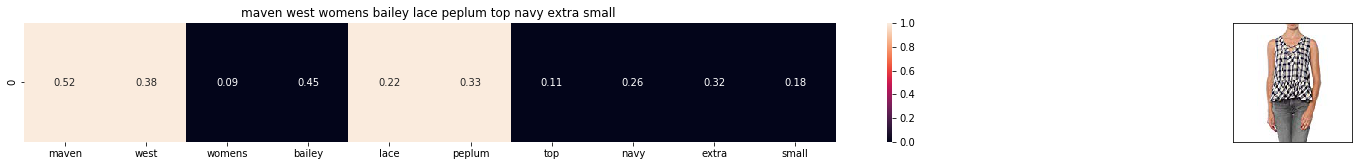

ASIN : B0719RM5M9
BRAND : Maven West
Eucliden distance from the given image : 0.8986550399683086


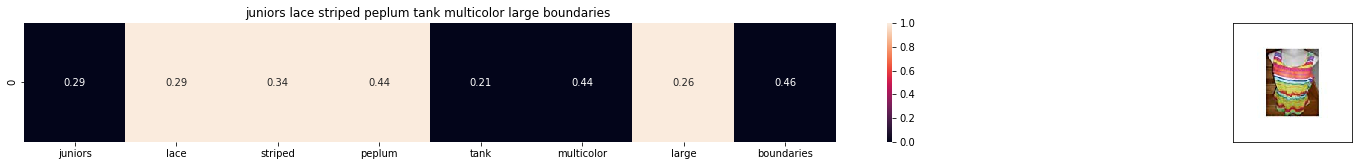

ASIN : B01F2UCSS4
BRAND : No Boundaries
Eucliden distance from the given image : 1.1310797566240824


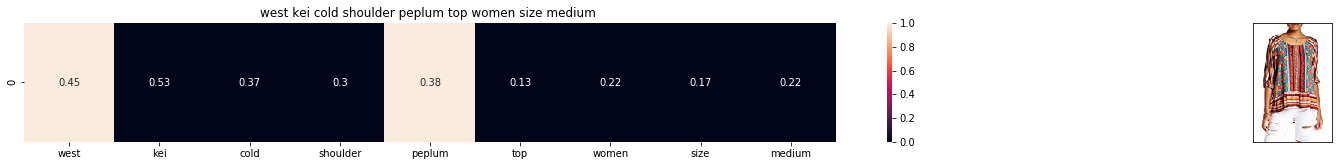

ASIN : B01N4T61UR
BRAND : West Kei
Eucliden distance from the given image : 1.1759994769844477


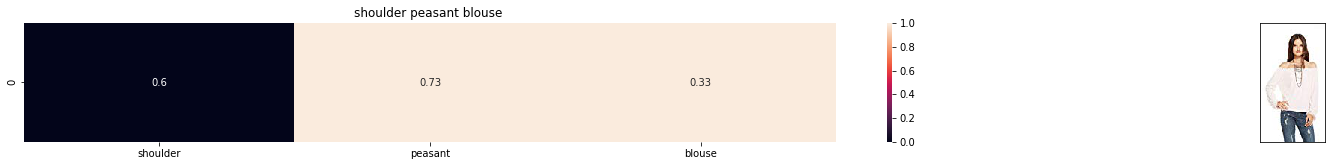

ASIN : B01E1QD5PK
BRAND : CHASER
Eucliden distance from the given image : 1.1917844463200697
Average euclidean distance is 0.8795037439793818


In [26]:
print('Getting the similar items for document id and number of items')
tfidf_model(5000, 5)

## 3. IDF BASED PRODUCT SIMILARITY

In [0]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [0]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [0]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val

In [0]:
idf_euclidean=[]
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        idf_euclidean.append(pdists[i])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)
    print('Average euclidean distance is ',sum(idf_euclidean)/num_results)

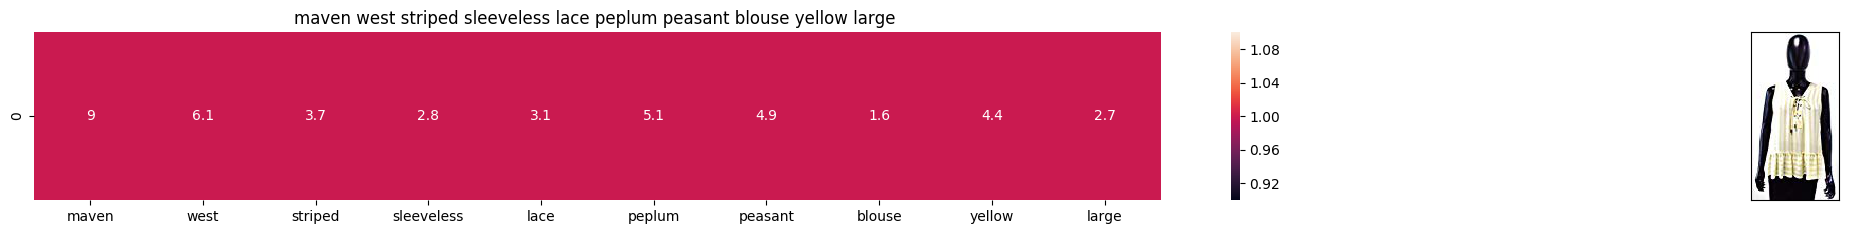

ASIN : B01M8GB3AL
Brand : Maven West
euclidean distance from the given image : 0.0


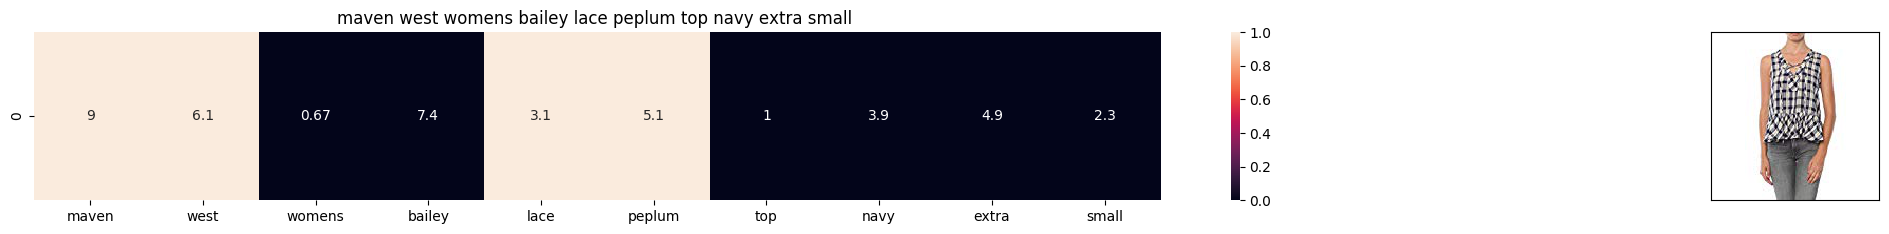

ASIN : B0719RM5M9
Brand : Maven West
euclidean distance from the given image : 13.236575207126352


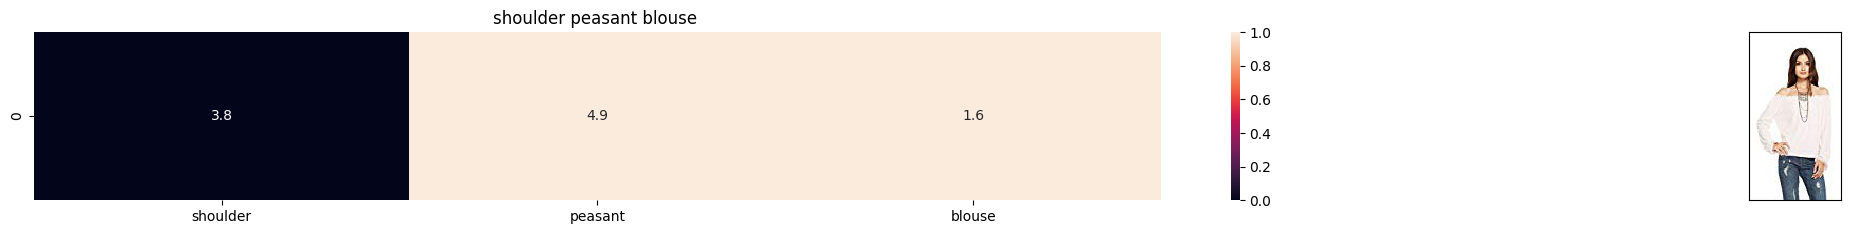

ASIN : B01E1QD5PK
Brand : CHASER
euclidean distance from the given image : 14.704606649764475


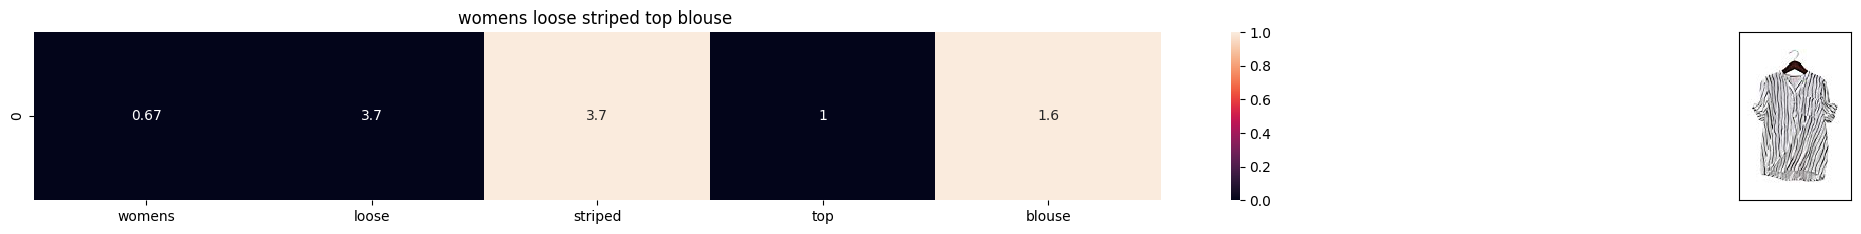

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 15.07810883965776


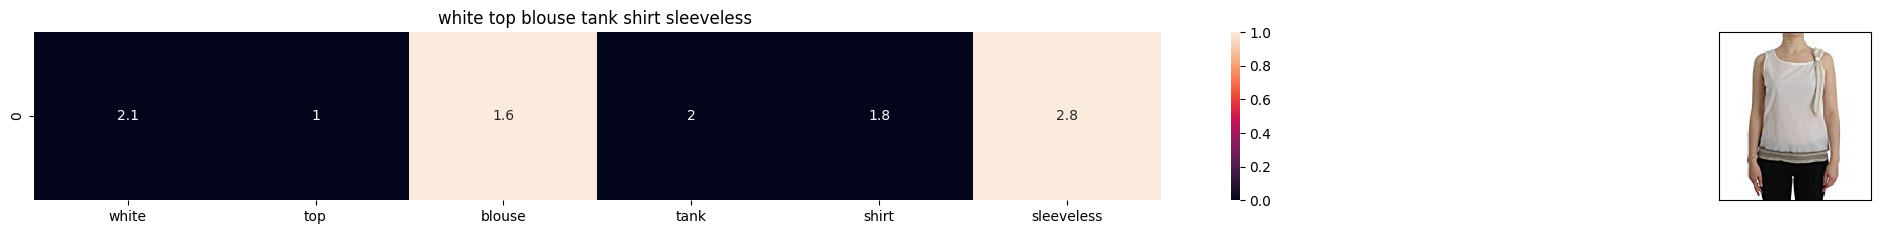

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 15.174383199935471
Average euclidean distance is  11.638734779296811


In [32]:
idf_model(5000,5)

In [64]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

Using TensorFlow backend.


## 7.VISUAL FEATURES BASED PRODUCT SIMILARITY

In [65]:
#Do NOT run this code unless you want to wait a few hours for it to generate output
# each image is converted into 25088 length dense-vector
'''
# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'images2/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

'''

"\n# dimensions of our images.\nimg_width, img_height = 224, 224\n\ntop_model_weights_path = 'bottleneck_fc_model.h5'\ntrain_data_dir = 'images2/'\nnb_train_samples = 16042\nepochs = 50\nbatch_size = 1\n\n\ndef save_bottlebeck_features():\n    \n    #Function to compute VGG-16 CNN for image feature extraction.\n    \n    asins = []\n    datagen = ImageDataGenerator(rescale=1. / 255)\n    \n    # build the VGG16 network\n    model = applications.VGG16(include_top=False, weights='imagenet')\n    generator = datagen.flow_from_directory(\n        train_data_dir,\n        target_size=(img_width, img_height),\n        batch_size=batch_size,\n        class_mode=None,\n        shuffle=False)\n\n    for i in generator.filenames:\n        asins.append(i[2:-5])\n\n    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)\n    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))\n    \n    np.save(open('16k_data_cnn_features.npy', 'w

In [0]:
get_similar_products_cnn(12566, 20)

### Comparing the models

In [0]:
euclidean_distance=[]
num_results=5
euclidean_distance.append(sum(bag_of_words_euclidean)/num_results)
euclidean_distance.append(sum(tf_idf_euclidean)/num_results)

x=euclidean_distance
y=[]
for i in range(0,4,2):
    y.append(i)

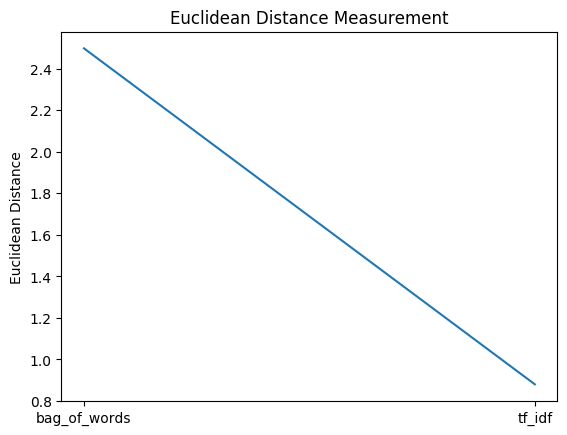

In [71]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('bag_of_words', 'tf_idf')
y_pos = np.arange(len(objects))
plt.plot(y,x)
plt.xticks(y, objects)
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Measurement')
 
plt.show()

<BarContainer object of 2 artists>

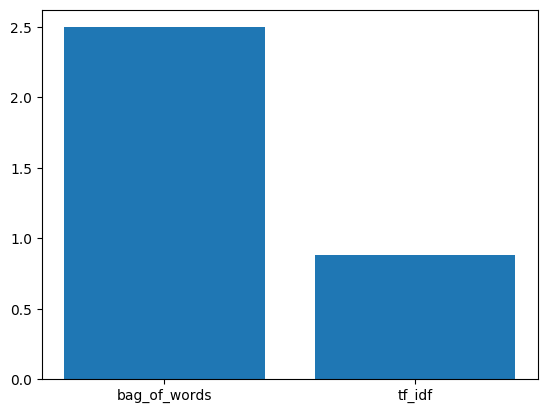

In [72]:
plt.bar(objects,x)